Here we are importing ObsPy modules to handle seismic data streams and UTCDateTime objects.
We will print a statement to screen to make sure this is working

In [1]:
from obspy import Stream, UTCDateTime
print("Hello World, I ran this cell!")

Hello World, I ran this cell!


Now we also import the Client Function to make Data Requests. We initialize the client object and here are setting it to pull data from IRIS

In [4]:
from obspy.clients.fdsn import Client
client = Client("IRIS")
print(client)

FDSN Webservice Client (base url: http://service.iris.edu)
Available Services: 'dataselect' (v1.1.9), 'event' (v1.1.13), 'station' (v1.1.52), 'available_event_catalogs', 'available_event_contributors'

Use e.g. client.help('dataselect') for the
parameter description of the individual services
or client.help() for parameter description of
all webservices.


First let's find some Earthquakes. 

We will search for events of Magnitude 7 or larger that have happened this year. These Earthquakes are detected by agencies across the glove and characteristics of the earthquake (Magnitude, location, time, slip-mechanism) are cataloged by the [U.S. Geological Survey National Earthquake Information Center](https://www.usgs.gov/programs/earthquake-hazards/national-earthquake-information-center-neic). The catalog gives you the time origin time of each event, the Epicenter location, and the size of the Earthquake.  


In [5]:
stime = UTCDateTime("2023-01-01")
etime = UTCDateTime("2023-05-30")
My_Earthquakes = client.get_events(starttime=stime,endtime=etime,minmagnitude=7.0,catalog="NEIC PDE")
print(My_Earthquakes.__str__(print_all=True))

13 Event(s) in Catalog:
2023-05-20T01:51:01.088000Z | -23.062, +170.456 | 7.1  mww
2023-05-19T02:57:03.129000Z | -23.185, +170.763 | 7.7  mww
2023-05-10T16:02:00.451000Z | -15.600, -174.608 | 7.6  mww
2023-04-24T20:00:57.540000Z |  -0.803,  +98.524 | 7.1  Mww
2023-04-24T00:41:53.607000Z | -29.992, -177.811 | 7.1  mww
2023-04-14T09:55:45.265000Z |  -6.026, +112.033 | 7.0  mww
2023-04-02T18:04:11.321000Z |  -4.326, +143.159 | 7.0  mww
2023-03-16T00:56:00.139000Z | -30.174, -176.198 | 7.0  Mww
2023-02-06T10:24:49.258000Z | +38.023,  +37.203 | 7.5  mww
2023-02-06T01:17:34.362000Z | +37.225,  +37.021 | 7.8  mww
2023-01-18T06:06:11.334000Z |  +2.736, +127.027 | 7.0  mwc
2023-01-09T17:47:35.057000Z |  -7.064, +130.004 | 7.6  mww
2023-01-08T12:32:42.372000Z | -14.947, +166.879 | 7.0  mww


**Excercise: What was the largest earthquake on your birthday?** Use the cell below to see where it was! 

**Bonus excercise: Get all earthquakes of M>7 since you were born. Where are most of the earthquakes occuring?**

We can quickly plot where these earthquakes are in Obspy! 

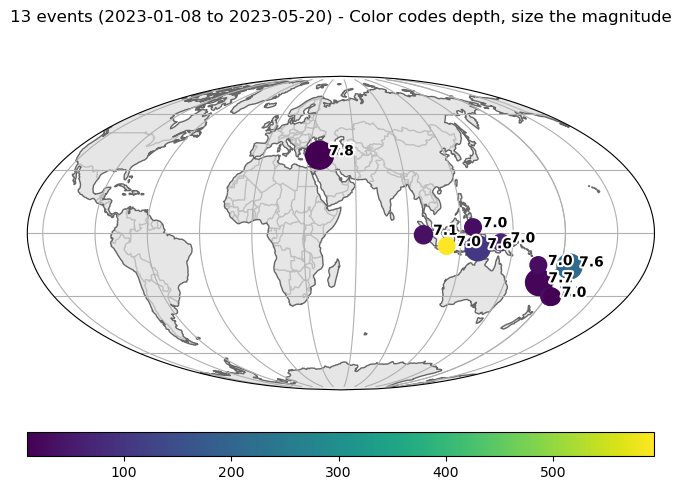

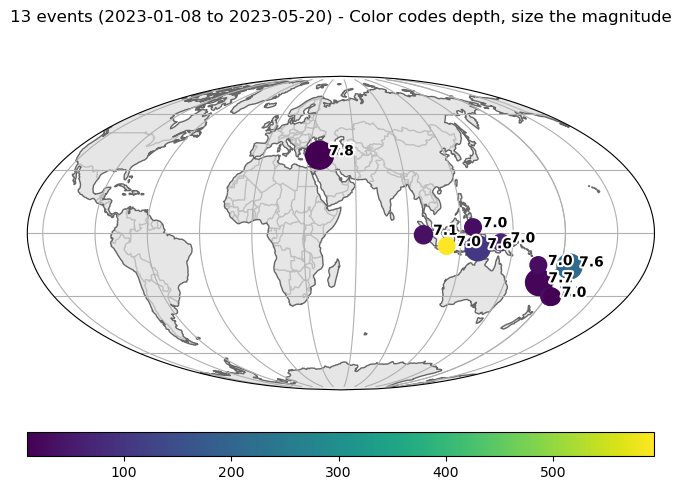

In [6]:
My_Earthquakes.plot()

Now that we have some earthquakes, what do we need to see how the ground moved? Seismic Data! 

We will create an "inventory object" to find seismic stations

Let's look at the Global Seismographic Network (USGS portion has network code "IU") to see which stations are available. To simplify, we will just look at stations that end in the leter "O." Below we use the wild card * to indicate that we don't care what the station name starts with as long as it ends on "O." Many of these stations were installed as part of a borehole seismometer network called the Seismic Research Observatory in the 1970s. 

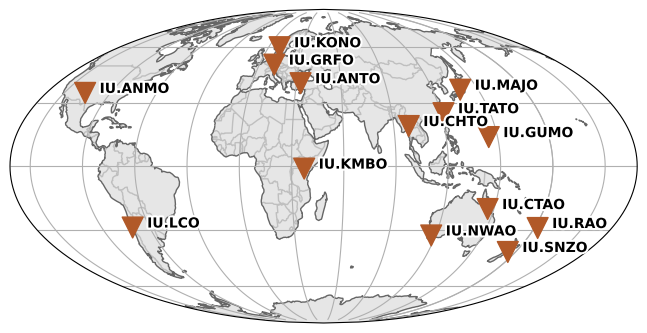

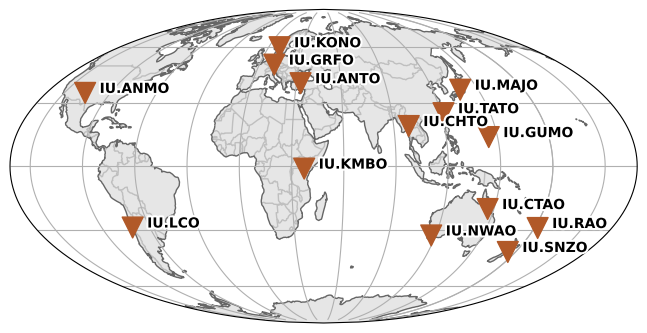

In [7]:
My_stations = client.get_stations(network="IU", station="*O",starttime=stime,endtime=etime,level='response')
My_stations.plot()

Our SNCL puzzle for seismic data is now halfway complete. We have network (IU) and stations (for instance NWAO). What locations and channels of data can we get from this station?

2 options (let's do both to see if they agree!): 

1) manually search the [IRIS MDA](http://ds.iris.edu/mda/IU/NWAO/)
2) Get the information from the "inventory object" we created 

Let's say we want vertical component ground motion sampled at 1 sample per second. We can find this by searching for channgels that have the code "L?Z"

    Where L indicates 1 sample per second 
    ? is a wild card (we will accept any letter in this spot)
    Z indicates vertical component 

you can learn more about channel codes [here](https://ds.iris.edu/ds/nodes/dmc/data/formats/seed-channel-naming/)

We will now look for the location codes of seismic instruments that record vertical component ground motion at the GSN station NWAO


In [9]:
station_info = My_stations.select(station="NWAO", channel="L?Z")
print(station_info)

Inventory created at 2023-05-23T18:07:42.017500Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.52
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2023-01-...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			IU
		Stations (1):
			IU.NWAO (Narrogin, Australia)
		Channels (3):
			IU.NWAO.00.LHZ, IU.NWAO.10.LHZ, IU.NWAO.20.LNZ


We have 3 sensors that match our request:
1. 00 LHZ
2. 10 LHZ
3. 20 LNZ

**Question: Which of these channels is different from the others? Think about why (hint read the channel code docs above).** 

Does it matter that this sensor is differentwhen we look at seismic data? Let's find out! 

The first step to get our data is to use the SNCL. Have data from 3 sensors, so we will have 3 location codes. Let's write a happy little "for loop" to get a little more information on each of our sensors. 

In [10]:
for channel in station_info[0][0]:
    print(channel)
    

Channel 'LHZ', Location '00' 
	Time range: 2018-09-15T00:00:00.000000Z - --
	Latitude: -32.9277, Longitude: 117.2390, Elevation: 278.1 m, Local Depth: 102.0 m
	Azimuth: 0.00 degrees from north, clockwise
	Dip: -90.00 degrees down from horizontal
	Channel types: CONTINUOUS, GEOPHYSICAL
	Sampling Rate: 1.00 Hz
	Sensor (Description): None (Streckeisen STS-6A VBB Seismometer)
	Response information available
Channel 'LHZ', Location '10' 
	Time range: 2016-01-18T02:00:00.000000Z - --
	Latitude: -32.9277, Longitude: 117.2390, Elevation: 380.1 m, Local Depth: 0.0 m
	Azimuth: 0.00 degrees from north, clockwise
	Dip: -90.00 degrees down from horizontal
	Channel types: CONTINUOUS, GEOPHYSICAL
	Sampling Rate: 1.00 Hz
	Sensor (Description): None (Streckeisen STS-2 Standard-gain)
	Response information available
Channel 'LNZ', Location '20' 
	Time range: 2022-06-19T06:16:00.000000Z - --
	Latitude: -32.9277, Longitude: 117.2390, Elevation: 380.1 m, Local Depth: 0.0 m
	Azimuth: 0.00 degrees from north,

**Question: Which sensor above is the deepest? How Deep?**

**Question: What type of sensor is the 20 location code? Is this what you would expect for "LNZ" data?**


We're now going to look at data 2 days of data from May 19th to May 21st on NWAO

We will specify the Network (IU), station name, the locations, and the channels we want to look at (as determined above)

We will also initilize a stream object to store the seisimic data. 

Then finally, for each seismic instrument, we will request data from IRIS and print out what we got.

 **Question: Before you run this cell below, how many different seismograms (called a "Trace" in ObsPy Speak) do you expect to receive?**
 
 print(My_data)

In [11]:
start_of_data = UTCDateTime("2023-05-19T00:00:00")
end_of_data = UTCDateTime("2023-05-21T00:00:00")

net = "IU"
sta = "NWAO"
locs = ["00", "10", "20"]
chan = "L?Z"


My_data = Stream()
for loc in locs:
    My_data += client.get_waveforms(network=net, station = sta,
    location = loc, channel = chan, starttime = start_of_data, endtime = end_of_data) 
    
print(My_data)

3 Trace(s) in Stream:
IU.NWAO.00.LHZ | 2023-05-19T00:00:00.069539Z - 2023-05-20T23:59:59.069539Z | 1.0 Hz, 172800 samples
IU.NWAO.10.LHZ | 2023-05-19T00:00:00.069538Z - 2023-05-20T23:59:59.069538Z | 1.0 Hz, 172800 samples
IU.NWAO.20.LNZ | 2023-05-19T00:00:00.069538Z - 2023-05-20T23:59:59.069538Z | 1.0 Hz, 172800 samples


Now let's look at some data! Anything interesting happenining a few weeks ago? 

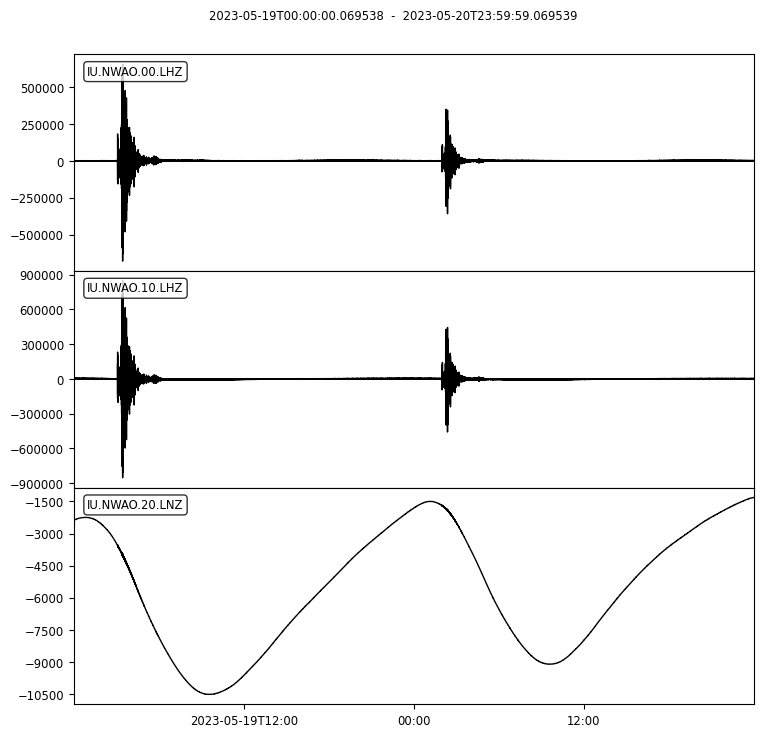

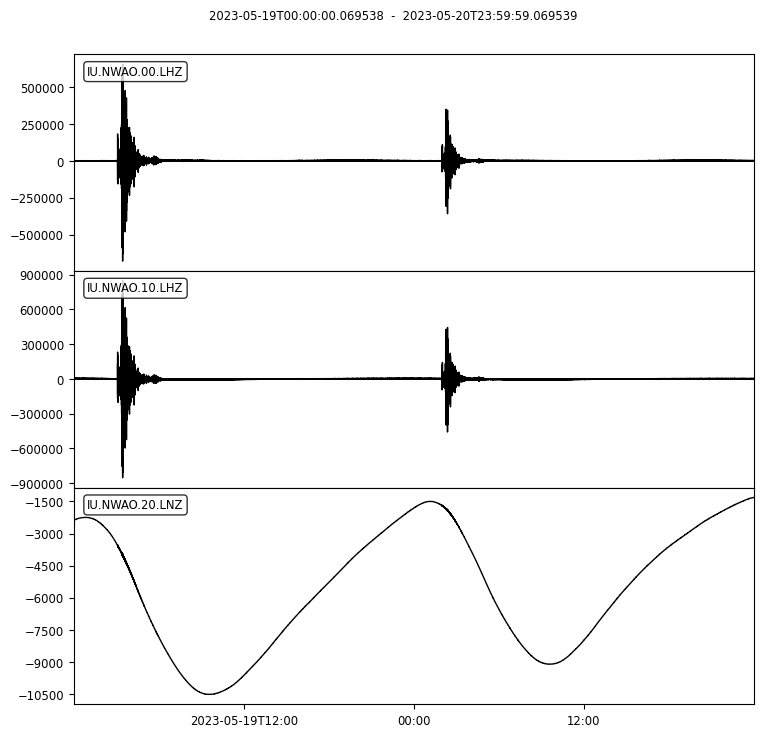

In [12]:
My_data.plot(equal_scale=False)

Note that the scale of the plots are different. **Question: What are the units of the y-axis?** 

**Something to thing about: We have large signals around 03:00 on May 19th and 02:00 on May 20th on both the "00" and "10" sensors, but the signal is barely visibile on the "20" - think about why this might be. What's different about this sensor?** 

To compare apples to apples, let's look at ground velocity on all the sensors. To do this we will remove the response. We will then multiply by a one million (any idea why?)

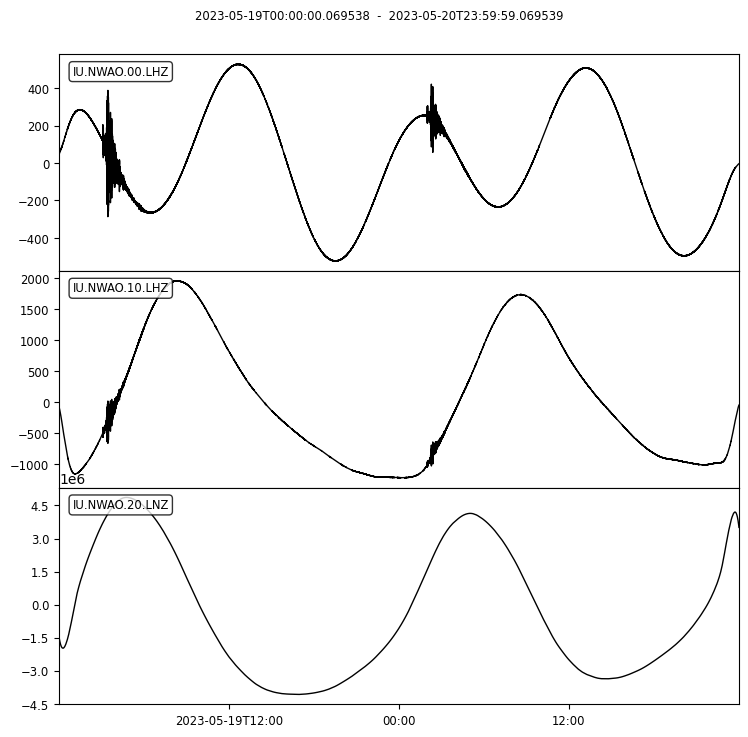

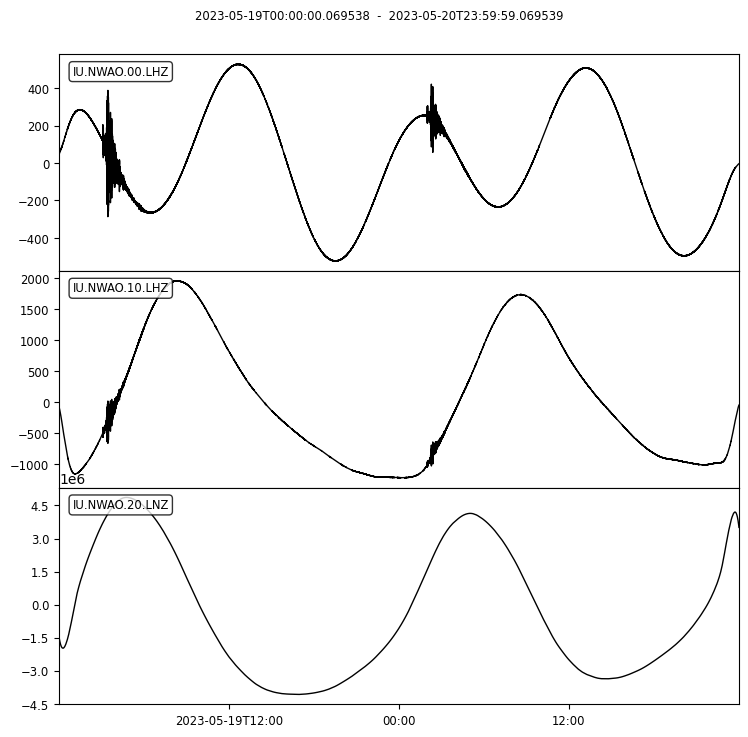

In [13]:
My_data.remove_response(inventory=My_stations, output='VEL')
for trace in My_data:
    trace.data*=1E6
My_data.plot(equal_scale=False)

**Question: What are the units on the Y-axis now?** 

**Something to think about: We have a really large signal that peaks about twice a day on the "00" sensor - Any idea what that is? In contrast - we have even larger signals that peak once a day (around 1 to 5 pm local time - keep in mind the time on the X-axis is UTC!). Any idea what this is?** 

Let's highpass filter out these very long signals and only focus on seismic energy below 1000 s period (oscillation of the ground that are faster than once every ~17 minutes). Recall that frequency is the inverse of period. 


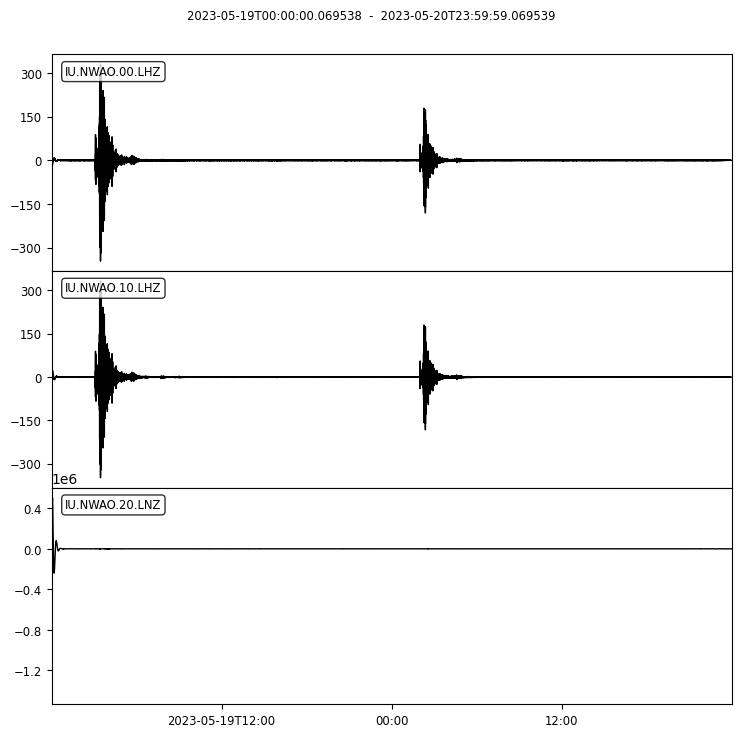

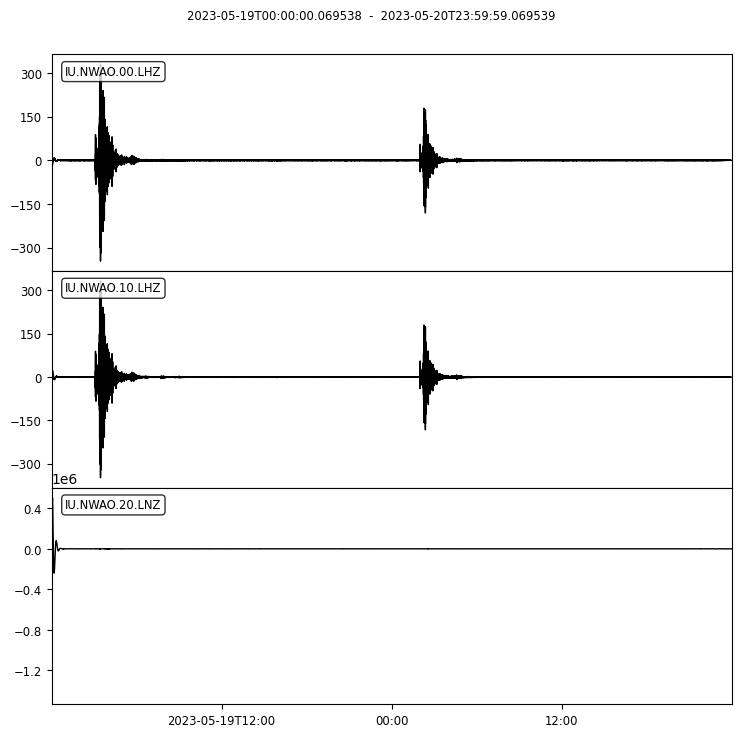

In [14]:
My_data.filter("highpass", freq=1/1000.)
My_data.plot(equal_scale=False)


Hmmm.....What's that big signal at the start of "20" sensor? It's filter ring from applying the high-pass filter. We will trim out data to remove that. Let's focus only of the large signal on May 20th

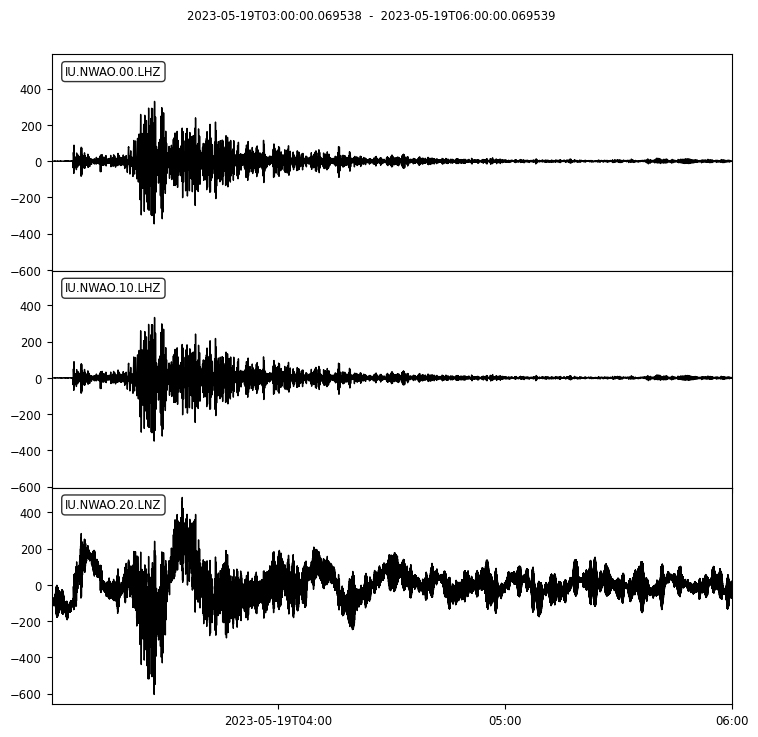

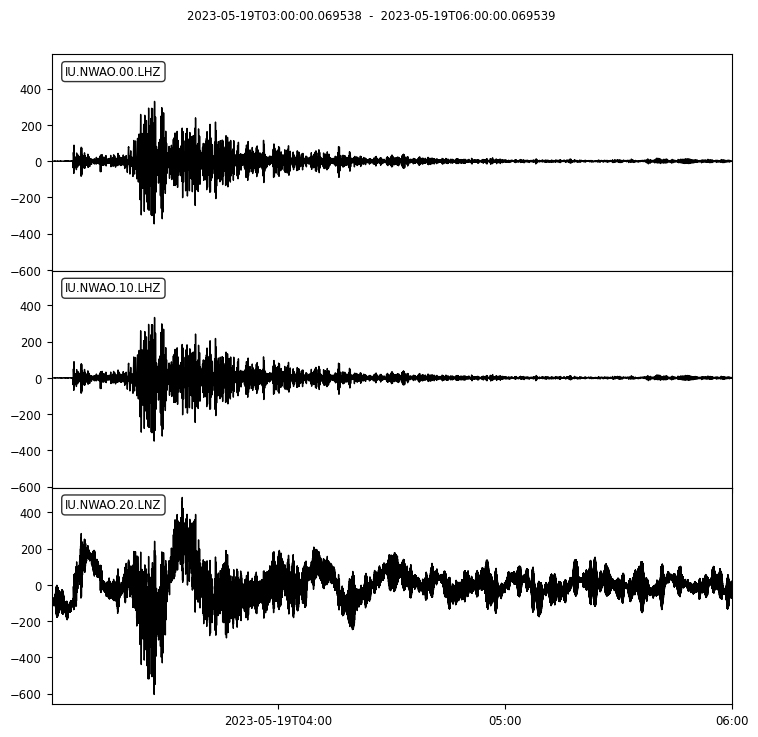

In [15]:
trim_start = UTCDateTime("2023-05-19T03:00:00")
trim_end =  UTCDateTime("2023-05-19T06:00:00")

My_trimmed_data = My_data.copy()
My_trimmed_data.trim(trim_start,trim_end)


My_trimmed_data.plot()

Alright, now we have some data! **Question: Which sensor looks different than the others? Any idea Why?**

REVIEW:

We initiated an IRIS client and used it to pull Earthquakes from the National Earthquake Informatin Center Catalog

We used the same client to find seismic stations, and get information about them (type of instruments and data available, response information). This information is also available from the MDA

We then used the SNCL of a seismic station to request data for an Earthquake 

We removed the response, and filtered the data to get a better view of the Earthquake
